In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter,gaussian_filter1d
from matplotlib import colors

In [3]:
import pyvisa
#from scqubits.core.fluxonium import Fluxonium
#matplotlib.rcdefaults()

In [4]:
rm = pyvisa.ResourceManager()

In [5]:
rm.list_resources()

('TCPIP0::A-N5173B-280417::hislip0::INSTR',
 'TCPIP0::A-N5173B-280417::inst0::INSTR',
 'TCPIP0::K-N9010B-40482.local::hislip0::INSTR',
 'TCPIP0::K-N9010B-40482.local::inst0::INSTR',
 'ASRL3::INSTR',
 'USB0::0x03EB::0xAFFF::915-0M1040000-0083::0::INSTR')

In [6]:
import qkit
qkit.cfg["run_id"] = "20230119_Sionludi2"
qkit.cfg["user"] = "Mathieu"
qkit.cfg['load_visa'] = True

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import sleep

from qkit.storage.store import Data
from qkit.analysis.circle_fit.circle_fit_2019 import circuit
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
#from qkit.measure.spectroscopy.spectroscopy import spectrum
qkit.start()
from qkit.measure.spectroscopy.spectroscopy import spectrum

QKIT configuration initialized -> available as qkit.cfg[...]
Starting QKIT framework ... -> qkit.core.startup
Loading module ... S10_logging.py
Loading module ... S14_setup_directories.py
Loading module ... S16_available_modules.py
Loading module ... S20_check_for_updates.py
Loading module ... S25_info_service.py
Loading module ... S30_qkit_start.py
Loading module ... S65_load_RI_service.py
Loading module ... S70_load_visa.py
Loading module ... S80_load_file_service.py
Loading module ... S85_init_measurement.py


Loading module ... S98_started.py
Loading module ... S99_init_user.py


In [7]:
mw_drive_address = 'TCPIP0::192.168.1.42::inst0::INSTR'
mw_drive = qkit.instruments.create('mw_drive','Keysight_N5173B',address=mw_drive_address)

In [542]:
mw_drive.set_power(5.6)

True

In [612]:
mw_drive.get_power()

5.6

In [8]:
from presto import lockin

In [9]:
presto_address = "192.168.1.103"

In [10]:
def IQtoval(IQ):
    I = real(IQ)
    Q = imag(IQ)
    pol = polyfit(I,Q,deg = 1)
    z = (I+1j*Q)*exp(1j*-arctan(pol[0]))
    return real(z)

In [11]:
if 1:
    #For flux
    yoko_address='TCPIP0::192.168.1.65::inst0::INSTR'
    yoko = qkit.instruments.create('current', 'Yokogawa_GS200', address=yoko_address)
    #yoko_address_dja='TCPIP0::192.168.1.201::inst0::INSTR'
    #yoko_dja = qkit.instruments.create('current_dja', 'Yokogawa_GS200', address=yoko_address_dja)

    yoko.get_level()#,yoko_dja.get_level()

Attention: Output is set on; Be careful!


In [12]:
data_folder =  'C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/'

Initialized the file info database (qkit.fid) in 0.495 seconds.


# frequency sweep 

In [469]:
import qkit.measure.presto.sweep as presto_sweep

In [470]:
from importlib import reload

In [577]:
reload(presto_sweep)

<module 'qkit.measure.presto.sweep' from 'C:\\qkit\\qkit\\measure\\presto\\sweep.py'>

In [783]:

# initialize the experiment
experiment = presto_sweep.Sweep({  'input_port' : 1,
                            'output_port' : 1,
                            'df' : 0.25e6,
                            'freq_center' : 7.35e9,
                            'freq_span' : 0.1e9,
                            'amp' : 0.005,
                            'num_averages' : 1000}
                            )

config_0 = { "adc_mode":   [1,1,1,1],
            "adc_fsample": [2,2,2,2],
            "dac_fsample": [5,5,4,4],
            "dac_mode":    [3,3,2,2]}
experiment.converter_config = config_0

In [1052]:
experiment.experiment_name = 'D7Qubit_sweep_simple8'
%time save_filename = experiment.run(presto_address)


Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_sweep_simple8
Wall time: 6.54 s


{'current': {'level': -0.003455,
  'output': 'on',
  'source_mode': 'CURR',
  'source_range': '10e-3\n'},
 'mw_drive': {'frequency': 7392700000.0,
  'power': 5.55,
  'power_offset': None,
  'status': True}}

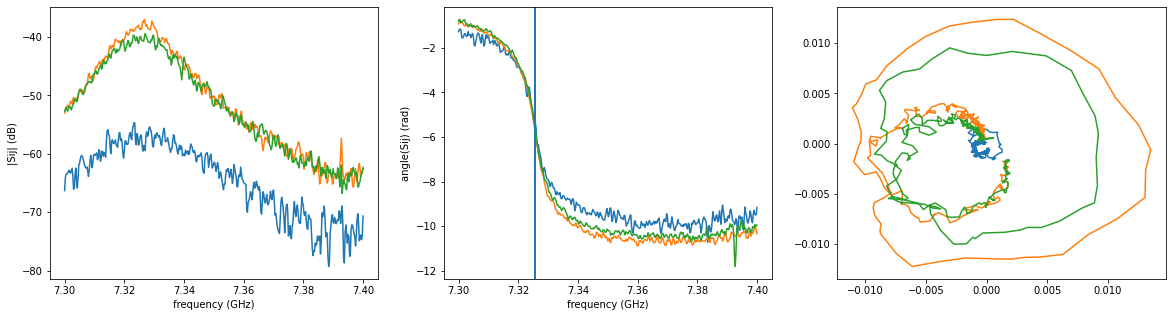

In [1053]:
from scipy.ndimage import gaussian_filter
fig,ax = subplots(1,3,figsize = (20,5))
phaseroll = 480

for name in [data_folder+'D7Qubit_sweep_simple_baseline',
             data_folder+'D7Qubit_sweep_simple7',
            data_folder+'D7Qubit_sweep_simple8',]:
    expe = experiment.load(name)
    f = expe.freq_arr
    out = expe.resp_arr
    Sij = gaussian_filter(((out)/expe.amp )*exp(1j*f*phaseroll*1e-9),0.8)
    if 1:
        ax[0].plot(f/1e9,20*log10(abs(Sij)))
        ax[1].plot(f/1e9,unwrap(angle(Sij)))
        ax[0].set_xlabel('frequency (GHz)')
        ax[0].set_ylabel('|Sij| (dB)')
        ax[1].set_ylabel('angle(Sij) (rad)')
        ax[1].set_xlabel('frequency (GHz)')
        ax[2].plot(real(Sij),imag(Sij))
    ax[1].axvline(7.3255)
expe.settings

#  Coil sweep 

## with external yoko bias

In [590]:
import qkit.measure.presto.sweep_coil_yoko as presto_sweep_coil_yoko

In [591]:
reload(presto_sweep_coil_yoko)

<module 'qkit.measure.presto.sweep_coil_yoko' from 'C:\\qkit\\qkit\\measure\\presto\\sweep_coil_yoko.py'>

In [592]:

experiment_coil_yoko = presto_sweep_coil_yoko.SweepCoil({  'input_port' : 1,
                            'output_port' : 1,
                            'df' : 0.5e6,
                            'freq_center' : 7.33e9,
                            'freq_span' : 0.05e9,
                            'amp' : 0.005,
                            'dither' : True,
                            'num_skip' : 0 ,
                            'num_averages' : 5000,
                            'bias_port' : 1,
                            'bias_arr': linspace(-4.2e-3,-2.8e-3,25),
                            '_qubit_bias_function' : lambda cur : yoko.ramp_current(cur,1e-5)}
                            )

In [593]:
experiment_coil_yoko.experiment_name = 'D7Qubit_sweep_coil_yoko_1'
%time save_filename = experiment_coil_yoko.run(presto_address)

 dc bias -0.003 V, iteration 25 over 25 / should end in 0.048 min Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_sweep_coil_yoko_1
Wall time: 1min 23s


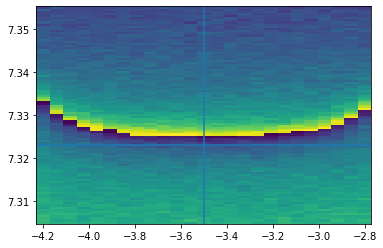

In [597]:
for name in [data_folder+'D7Qubit_sweep_coil_yoko_1']:
    expe = experiment_coil_yoko.load(name)
    out  = expe.resp_arr
    freq = expe.freq_arr/1e9
    out  = angle(((out)/expe.amp)*exp(1j*freq*470))
    bias = expe.bias_arr/1e-3
    pcolormesh(bias,freq,out.T,shading = 'nearest')
axvline(-3.5)
axhline(7.323)

# Two tone bias sweep

## With dc yoko

In [598]:
import qkit.measure.presto.two_tone_bias_sweep_yoko as presto_two_tone_bias_sweep_yoko

In [599]:

# initialize the experiment
experiment_two_tone_yoko = presto_two_tone_bias_sweep_yoko.TwoToneBiasSweep({
            'readout_freq' : 7.325e9,
            'control_freq_center' : 4.2e9,
            'control_freq_span' : 0.3e9*2,
            'df' : 1e6,
            'num_averages' : 2000,
            'readout_amp':0.03,
            'control_amp':0.5,
            'bias_arr': -3.5e-3 +linspace(-0.2e-3,0.2e-3,21) ,
            'input_port' : 1,
            'control_port':3,
            'readout_port': 1,
            '_qubit_bias_function': lambda cur : yoko.ramp_current(cur,2e-5)})

In [600]:
experiment_two_tone_yoko.experiment_name = 'D7Qubit_experiment_two_tone_yoko1'
%time save_filename = experiment_two_tone_yoko.run(presto_address)

 dc bias -0.003 V, iteration 21 over 21 / should end in 0.0 min and 9 secondsData saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_experiment_two_tone_yoko1
Wall time: 3min 9s


-3.480808

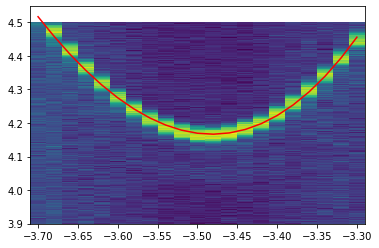

In [601]:
f_fluxo = []
bias_fluxo = []

expe = experiment_two_tone_yoko.load(data_folder+'D7Qubit_experiment_two_tone_yoko1')
out = ((expe.resp_arr))
out = unwrap(angle(out))
freq = expe.control_freq_arr
bias = expe.bias_arr/1e-3
pcolormesh(bias,freq/1e9,out.T,shading = 'nearest')
f_fluxo = concatenate((f_fluxo,freq[argmax(out,axis = 1)]))
bias_fluxo = concatenate((bias_fluxo,bias))

if 1:
    a = argsort(bias_fluxo)
    bias_fluxo = bias_fluxo[a]
    f_fluxo = f_fluxo[a]
    #plot(bias_fluxo,f_fluxo/1e9,'r')
    pol = polyfit(bias_fluxo,f_fluxo,deg = 3)
    plot(bias_fluxo,polyval(pol,bias_fluxo)/1e9,'r')
    dc_bias_0 = linspace(-3.6,-3.4,100)[argmin(polyval(pol,linspace(-3.6,-3.4,100)))]
    dc_bias_0 = round(dc_bias_0,6)
dc_bias_0 

In [602]:
yoko.ramp_current(-3.481*1e-3,2e-5)

In [603]:
yoko.get_level()

-0.003481

# Pulse check 

In [604]:
import qkit.measure.presto.pulse_check as presto_pulse_check

In [605]:
reload(presto_pulse_check)

<module 'qkit.measure.presto.pulse_check' from 'C:\\qkit\\qkit\\measure\\presto\\pulse_check.py'>

In [613]:
experiment_simple_pulse = presto_pulse_check.SimplePulse({ 
                                        'readout_freq' : 7.3255e9,
                                        'num_averages' : 200000,
                                        'readout_amp' : 0.1,
                                        'readout_duration' : 500e-9,
                                        'sample_duration' : 2000e-9,
                                        'sample_port' : 1,
                                        'readout_port': 1,
                                        'readout_sample_delay' : 200e-9,
                                        'wait_delay' : 50e-6})

In [614]:
experiment_simple_pulse.experiment_name = 'D7Qubit_simple_pulse_2'
%time save_filename = experiment_simple_pulse.run(presto_address)

Measurement sequence processed in 997.1us
Expected measurement time: 10.1s
Uploading measurement parameters: 103.8ms
Measurement completed in: 10.4s
Total time: 10.7s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_simple_pulse_2
Wall time: 11.6 s


850

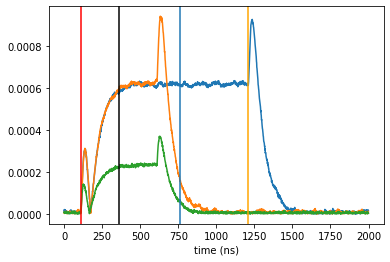

In [1060]:
for i in range(3):
    expe = experiment_simple_pulse.load(data_folder+f'D7Qubit_simple_pulse_{i}')
    plot(expe.t_arr/1e-9,abs(expe.store_arr[0,0]))
    xlabel('time (ns)')
axvline(110, color = 'red')
axvline(110+250, color = 'black')
axvline(110+1100, color = 'orange' )
axvline(110+650)
1100-250

# Two tone pulse


In [616]:
import qkit.measure.presto.two_tone_pulsed as presto_two_tone_pulsed

In [617]:
reload(presto_two_tone_pulsed)

<module 'qkit.measure.presto.two_tone_pulsed' from 'C:\\qkit\\qkit\\measure\\presto\\two_tone_pulsed.py'>

In [640]:
experiment_two_tone_pulsed = presto_two_tone_pulsed.TwoTonePulsed({
            'readout_freq' : 7.327e9,
            'control_freq_center' : 4.133e9,
            'control_freq_span' : 0.02e9,
            'control_freq_nr' : 201,
            'num_averages' : 5000,
            'readout_amp':0.1,
            'control_amp':0.4,
            'readout_duration': 1100e-9,
            'control_duration' : 400e-9,
            'sample_duration' : (1100-250)*1e-9,
            'readout_sample_delay':(100+250)*1e-9,
            'sample_port' : 1,
            'control_port':3,
            'readout_port': 1,
            'wait_delay' : 50e-6})

In [636]:
mw_drive.set_power(5.55)
mw_drive.set_status(False)

True

In [641]:
amps = linspace(0.2,0.6,2)

if 1:
    for i in range(len(amps)):
        experiment_two_tone_pulsed.control_amp = amps[i]
        experiment_two_tone_pulsed.experiment_name = f'two_tone_pulsed/D7Qubit_two_tone_pulsed_{i}_1'
        experiment_two_tone_pulsed.run(presto_address,print_time=False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/two_tone_pulsed/D7Qubit_two_tone_pulsed_0_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/two_tone_pulsed/D7Qubit_two_tone_pulsed_1_1


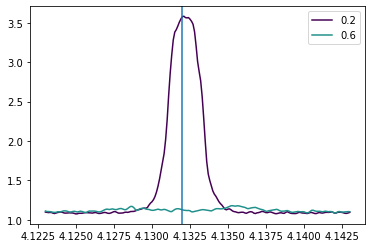

In [644]:
for i in range(len(amps)):
    expe = experiment_two_tone_pulsed.load(data_folder + f'two_tone_pulsed/D7Qubit_two_tone_pulsed_{i}_1')
    plot(expe.control_freq_arr/1e9,gaussian_filter(unwrap(angle(expe.store_arr[:,0,:].mean(-1))),1),color = cm.viridis(i/len(amps)))

axvline(4.132)
legend(amps)

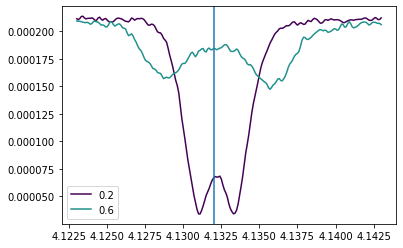

In [ ]:
for i in range(len(amps)):
    expe = experiment_two_tone_pulsed.load(data_folder + f'two_tone_pulsed/D7Qubit_two_tone_pulsed_{i}_1')
    plot(expe.control_freq_arr/1e9,gaussian_filter(abs(expe.store_arr[:,0,:].mean(-1)),1),color = cm.viridis(i/len(amps)))

axvline(4.132)
legend(amps)

# Cloud experiment

In [645]:
import qkit.measure.presto.IQ_cloud as presto_IQ_cloud

In [646]:
from importlib import reload
reload(presto_IQ_cloud)

<module 'qkit.measure.presto.IQ_cloud' from 'C:\\qkit\\qkit\\measure\\presto\\IQ_cloud.py'>

In [647]:

experiment_cloud = presto_IQ_cloud.IQCloud({
        'readout_freq': 7.3259e9,
        'control_freq' :4.1325e9,
        'readout_amp' : 0.19,
        'control_amp':0.15,
        'readout_duration': 1250e-9,
        'control_duration' : 300e-9,
        'match_duration' :(1000)*1e-9,
        'readout_match_delay' :  (110+250)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 40e-6,
        'num_repeat': 20000})



In [648]:
experiment_cloud.experiment_name = 'IQ_cloud_test_2'
experiment_cloud.run(presto_address)

Measurement sequence processed in 0.0e+00
Expected measurement time: 831.0ms
Uploading measurement parameters: 102.7ms
Measurement completed in: 1.1s
Total time: 1.5s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_test_2


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\IQ_cloud_test_2.h5'

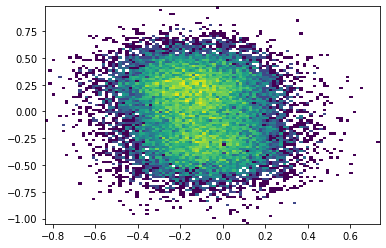

In [649]:
expe = experiment_cloud.load(data_folder+'IQ_cloud_test_2')
IQ =  experiment_cloud.match_arr
hist2d((IQ)[0],(IQ)[1],bins =100,norm = colors.LogNorm() );

In [106]:

freqs =7.3259e9 + linspace(-3e6,3e6,36)
for i_f in range(len(freqs)) :
    experiment_cloud.experiment_name = f'IQ_cloud_sweep/IQ_cloud_test_{i_f}'
    experiment_cloud.readout_freq = freqs[i_f]
    experiment_cloud.run(presto_address,print_time=False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_2
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_4
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_6
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_7
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_8
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_9
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/IQ_cloud_test_1

In [107]:

IQ = zeros((len(freqs),2,experiment_cloud.num_repeat))

freqs =7.3259e9 + linspace(-3e6,3e6,36)
for i_f in range(len(freqs)) :
    expe = experiment_cloud.load(data_folder+f'IQ_cloud_sweep/IQ_cloud_test_{i_f}')
    IQ[i_f] = expe.match_arr

In [108]:
from sklearn.mixture import GaussianMixture

In [109]:
mixture  = GaussianMixture(2, 
                     covariance_type='spherical', 
                     random_state=0)

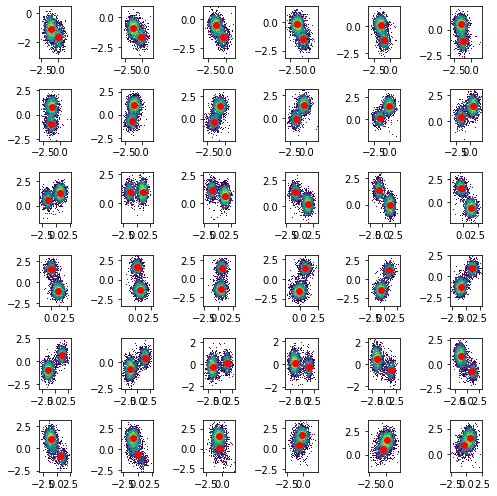

In [110]:
fig,ax  = subplots(6,6,figsize = (7,7))
cov_cloud = zeros((36,2))
dist_cloud = zeros((36))
for i_f in range(len(freqs)) :
    i,j = unravel_index(i_f,(6,6))
    IQ_ = IQ[i_f]
    gmm = mixture.fit(IQ_.T)
    ax[i,j].hist2d((IQ_)[0],(IQ_)[1],bins =100,norm = colors.LogNorm() );
    out = gmm.means_
    dist_cloud[i_f] = sqrt((out[0,0]-out[1,0])**2+(out[0,1]-out[1,1])**2)
    cov_cloud[i_f] = gmm.covariances_
    ax[i,j].scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'r')
    ax[i,j].scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
tight_layout()

Text(0, 0.5, 'IQ distance ')

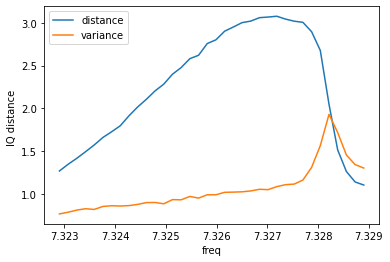

In [114]:
plot(freqs/1e9,dist_cloud,label = 'distance')
plot(freqs/1e9,2*cov_cloud.sum(-1),label = 'variance')
legend()
xlabel('freq')
ylabel('IQ distance ')

# Stark shift 

In [115]:
import qkit.measure.presto.stark_shift as presto_stark_shift

In [116]:
reload(presto_stark_shift)

<module 'qkit.measure.presto.stark_shift' from 'C:\\qkit\\qkit\\measure\\presto\\stark_shift.py'>

In [120]:
experiment_stark = presto_stark_shift.TwoTonePulsed({
            'readout_freq' : 7.327e9,
            'control_freq_center' : 4.14e9,
            'control_freq_span' : 0.03e9,
            'control_freq_nr' : 41,
            'num_averages' : 10000,
            'readout_amp':0.12,
            'readout_stark_arr':linspace(0,0.03,11),
            'control_amp':0.1,
            'readout_duration': 1000e-9,
            'control_duration' : 400e-9,
            'sample_duration' : (1000-250)*1e-9,
            'readout_sample_delay':(110+250)*1e-9,
            'sample_port' : 1,
            'control_port':3,
            'readout_port': 1,
            'wait_delay' : 50e-6})

In [121]:
experiment_stark.experiment_name = f'D7Qubit_stark_0'
experiment_stark.run(presto_address)

Measurement sequence processed in 22.9ms
Expected measurement time: 3m 54.5s
Uploading measurement parameters: 121.7ms
Measurement completed in: 3m 54.8s
Total time: 3m 55.4s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_stark_0.h5


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_stark_0.h5.h5'

[1.16787591e+01 3.24390060e-03]


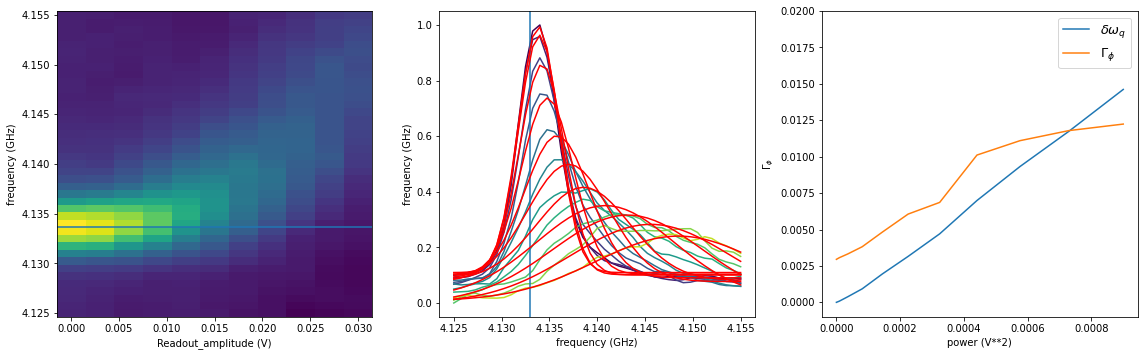

In [569]:
def normalizeData(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

fig,ax = subplots(1,3,figsize = (16,5))
expe = experiment_stark.load(data_folder + f'D7Qubit_stark_0')
out = expe.store_arr[:,0,:].mean(-1)
out = IQtoval(out)
out = out.reshape((len(expe.readout_stark_arr),expe.control_freq_nr))
out = (array([gaussian_filter1d((o),1) for o in out]).T)
out = normalizeData(out)
ax[0].pcolormesh(expe.readout_stark_arr,expe.control_freq_arr/1e9,out,shading = 'nearest')
ax[0].set_ylabel('frequency (GHz)')
ax[0].set_xlabel('Readout_amplitude (V)')

freq = expe.control_freq_arr/1e9
for i in range(len(expe.readout_stark_arr)):
    ax[1].plot(freq,(out.T[i]),color = cm.viridis(i/len(expe.readout_stark_arr)))
    ax[1].set_xlabel('frequency (GHz)')
    ax[1].set_ylabel('frequency (GHz)')
ax[1].axvline(4.133)
def fit_func(freq,f0,width,amp,baseline):
    return amp*exp(-((freq-f0)/width)**2)+baseline
p0 = 4.1327,0.035,0.15,0.0
delta_w = zeros(len(expe.readout_stark_arr))
gamma_phi = zeros(len(expe.readout_stark_arr))
for i in range(len(expe.readout_stark_arr)):
    try:
        p,_ = curve_fit(fit_func,freq,(out.T[i]),p0 = p0,bounds= [0,inf])
        ax[1].plot(freq,fit_func(freq,*p),'r')
        delta_w[i] = p[0]
        gamma_phi[i] = p[1]
    except:
        pass
delta_w -= delta_w[0]
ax[2].plot(expe.readout_stark_arr**2,delta_w,label = r'$\delta \omega_q$')
ax[2].plot(expe.readout_stark_arr**2,gamma_phi,label = r'$\Gamma_{\phi}$')
pol_numberofphotons = polyfit(expe.readout_stark_arr**2,gamma_phi,deg = 1)
print(pol_numberofphotons)
ax[2].set_xlabel('power (V**2)')
ax[2].set_ylabel( r'$\Gamma_{\phi}$',)
ax[2].legend(fontsize = 13)
fig.tight_layout()
ax[2].set_ylim(-0.001,0.02)

ax[0].axhline(4.1337)

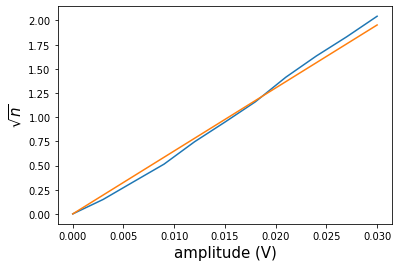

In [164]:
chi = 3.5e6
kappa = 3e6
plot(expe.readout_stark_arr,sqrt(delta_w*1e9/chi))
plot(expe.readout_stark_arr,65.12*expe.readout_stark_arr)
xlabel('amplitude (V)',fontsize = 15)
ylabel(r'$\sqrt{n}$',fontsize = 15)
sqrt_n_V = 65.37

## Cloud experiment

In [130]:
import qkit.measure.presto.IQ_cloud as presto_IQ_cloud

In [131]:
from importlib import reload
reload(presto_IQ_cloud)

<module 'qkit.measure.presto.IQ_cloud' from 'C:\\qkit\\qkit\\measure\\presto\\IQ_cloud.py'>

In [134]:

experiment_cloud = presto_IQ_cloud.IQCloud({
        'readout_freq': 7.3259e9,
        'control_freq' :4.13e9,
        'readout_amp' : 0.12,
        'control_amp':0.4,
        'readout_duration': 1250e-9,
        'control_duration' : 300e-9,
        'match_duration' :(1250 -250)*1e-9,
        'readout_match_delay' :  (110+250+200)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 40e-6,
        'num_repeat': 20000})



In [166]:
amps = linspace(0.06,0.16,6)
freqs =7.3259e9 + linspace(-7e6,7e6,36)

IQ = zeros((36,2,experiment_cloud.num_repeat))
for i_f in range(len(freqs)) :
    for j in range(len(amps)):
        experiment_cloud.readout_freq = freqs[i_f]
        experiment_cloud.readout_amp = amps[j]
        experiment_cloud.experiment_name = f'IQ_cloud_sweep/QD7_IQ_cloud_sweep_power_{i_f}_{j}'
        experiment_cloud.run(presto_address,print_time=False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_sweep/QD7_IQ_cloud_sweep_power_0_0


KeyboardInterrupt: 

In [167]:
from sklearn.mixture import GaussianMixture
from matplotlib import colors

In [168]:
mixture  = GaussianMixture(2, 
                     covariance_type='spherical', 
                     random_state=0)

In [169]:
angle_cloud = zeros((36,6,2))
cov_cloud = zeros((36,6,2))
dist_cloud = zeros((36,6))
for i_f in range(len(freqs)) :
    for j in range(len(amps)):

        expe = experiment_cloud.load(data_folder+f'IQ_cloud_sweep/QD7_IQ_cloud_sweep_power_{i_f}_{j}')
        IQ = expe.match_arr
        gmm = mixture.fit(IQ.T)
        out = gmm.means_
        dist_cloud[i_f,j] = norm(diff(out,axis = 0))
        a = out[0,0]+1j*out[0,1]
        b = out[1,0]+1j*out[1,1]
        angle_cloud[i_f,j] = [angle(a),angle(b)]
        cov_cloud[i_f,j] = gmm.covariances_


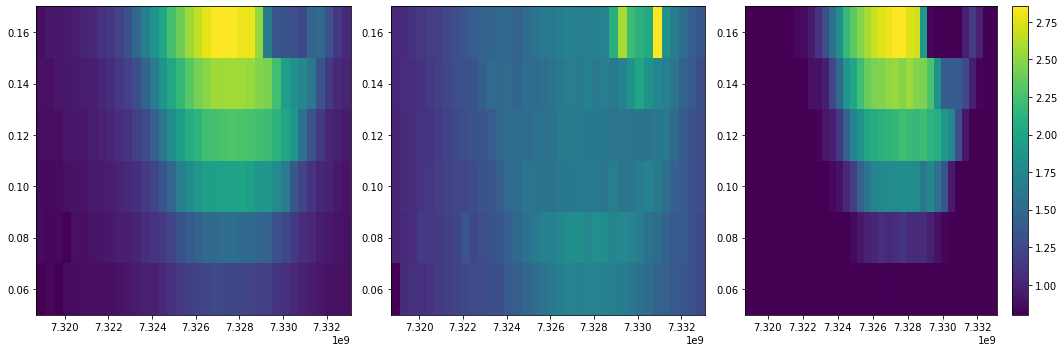

In [170]:
fig,ax = subplots(1,3,figsize = (15,5))
ax[0].pcolormesh(freqs,amps,dist_cloud.T,shading = 'nearest')

ax[1].pcolormesh(freqs,amps,cov_cloud.sum(-1).T*2,shading = 'nearest')
out = dist_cloud.T/cov_cloud.sum(-1).T/2
p = ax[2].pcolormesh(freqs,amps,out,shading = 'nearest',vmin = 0.8)
colorbar(p)
tight_layout()

#### Best separation for each readout power

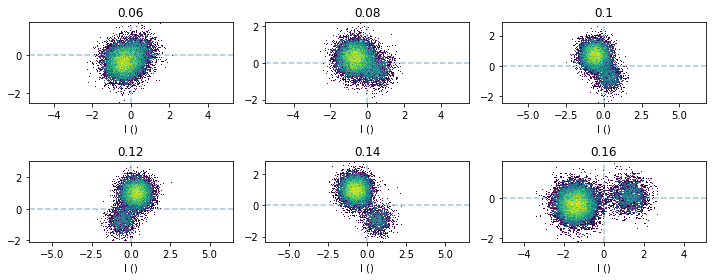

In [175]:
fig,ax = subplots(2,3,figsize = (10,4))
    
for j,i in enumerate(argmax(out,axis = 1)):
    ip,jp = unravel_index(j,(2,3))
    expe = experiment_cloud.load(data_folder+f'IQ_cloud_sweep/QD7_IQ_cloud_sweep_power_{i}_{j}')
    IQ = expe.match_arr
    gmm = mixture.fit(IQ.T)
    ax[ip,jp].hist2d((IQ)[0],(IQ)[1],bins = 100,norm = colors.LogNorm() );
    ax[ip,jp].axis('equal')
    ax[ip,jp].set_title(str(round(expe.readout_amp,3)))
for i in range(6):
    ip,jp = unravel_index(i,(2,3))
    ax[ip,jp].set_xlabel('Q')
    ax[ip,jp].set_xlabel('I ()')
    ax[ip,jp].axvline(0,alpha = 0.4,linestyle = 'dashed')
    ax[ip,jp].set_xlim(-2,2)
    ax[ip,jp].axhline(0,alpha = 0.4,linestyle = 'dashed')
tight_layout()

#### Chi

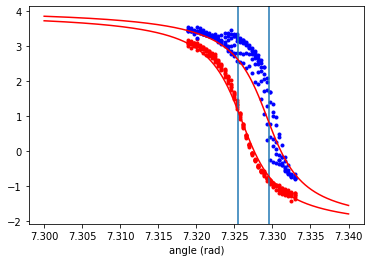

In [158]:
for N in range(6):
    A = np.array([unwrap(angle_cloud[:,N ,0]),unwrap(angle_cloud[:,N,1])])
    A = [((A[0])+950*freqs*1e-9-1)%(2*pi),((A[1])+950*freqs*1e-9-1)%(2*pi)]
    A = sort(A,axis = 0)
    A = sort(A,axis = 0)
    plot(freqs/1e9,(A[0])-pi/2,'r.')
    plot(freqs/1e9,(A[1])-pi/2,'b.')
xlabel('frequency (GHz)')
xlabel('angle (rad)')
axvline(7.3255)
axvline(7.3295)


def lorentz(freq,f0,k):
    return (((1-2*k/(1j*(freq-f0) + k))))

freq = linspace(7.3,7.34,1000)
p0 = 7.326,3.5e-3
plot(freq,unwrap(angle(lorentz(freq,*p0))+4),'r')
p0 = 7.3293,3.5e-3
plot(freq,unwrap(angle(lorentz(freq,*p0))+4.1),'r')

## rabi Oscillation

### Amplitude

In [650]:
import qkit.measure.presto.rabi_amp as presto_rabi_amp

In [651]:
from importlib import reload
reload(presto_rabi_amp)

<module 'qkit.measure.presto.rabi_amp' from 'C:\\qkit\\qkit\\measure\\presto\\rabi_amp.py'>

In [702]:
mw_drive.set_status(True)

True

In [703]:

experiment_rabi = presto_rabi_amp.RabiAmp({
        'readout_freq': 7.327e9,
        'control_freq' :4.1327e9,
        'readout_amp' : 0.1,
        'readout_duration': 500e-9,
        'control_duration' : 400e-9,
        'sample_duration' :(600 -250)*1e-9,
        'readout_sample_delay' :  (110+250)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 30e-6,
        'control_amp_arr' : linspace(0.03,0.99,100),
        'num_averages':10000,
})



In [704]:
experiment_rabi.experiment_name = 'D7Qubit_rabi_amp_4'
experiment_rabi.run(presto_address)

Measurement sequence processed in 997.3us
Expected measurement time: 30.9s
Uploading measurement parameters: 103.7ms
Measurement completed in: 31.2s
Total time: 31.5s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_rabi_amp_4


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_rabi_amp_4.h5'

150 ns, pi pulse at  0.596  V
100 ns, pi pulse at  0.866  V
400 ns, pi pulse at  0.205  V


Text(0.5, 0, 'amplitude (a.u.)')

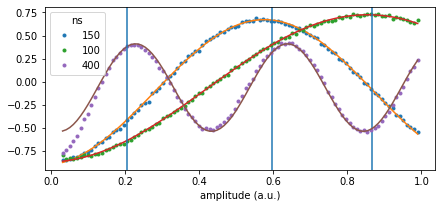

In [497]:

fig,ax  =subplots(1,figsize = (7,3))
for name in ['D7Qubit_rabi_amp_0',
            'D7Qubit_rabi_amp_1',
            'D7Qubit_rabi_amp_2']:
    rabi_exp = experiment_rabi.load(data_folder+name)
    amp_array = rabi_exp.control_amp_arr
    IQ = (rabi_exp.store_arr[:,0]).mean(-1)/1e-3
    out = IQtoval(IQ)
    freq_fft = fft.fftfreq(len(out),d = amp_array[1]-amp_array[0])
    ax.plot(amp_array,out,'.',label = round(rabi_exp.control_duration/1e-9))

    
    def quickfunc(t,a1,b1,w,t0):
        out = a1+b1*cos(2*pi*w*(t-t0))
        return out
    p0 = mean(out),max(out)-min(out),freq_fft[argmax(abs(fft.fft(out-out.mean())))],0.2
    p,_ = curve_fit(quickfunc,amp_array[5:],out[5:],p0 = p0)
    a1,b1,w,t0 =p
   
    
    out = quickfunc(amp_array,*p) 
    ax.plot(amp_array,out);
    ax.axvline(abs(1/2/w))
    print(round(rabi_exp.control_duration/1e-9),'ns, pi pulse at ',round(abs(1/2/w),3),' V')
legend(title = 'ns')
ax.set_xlabel('amplitude control pulse (mV)')
ax.set_xlabel('amplitude (a.u.)')


400 ns, pi pulse at  0.211  V
400 ns, pi pulse at  0.211  V


Text(0.5, 0, 'amplitude (a.u.)')

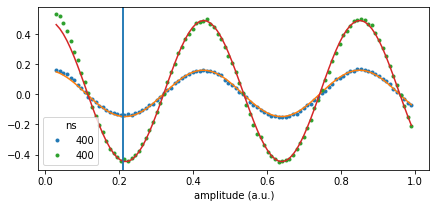

In [706]:
# no amp
# with amp

fig,ax  =subplots(1,figsize = (7,3))
for name in ['D7Qubit_rabi_amp_3',
             'D7Qubit_rabi_amp_4']:
    rabi_exp = experiment_rabi.load(data_folder+name)
    amp_array = rabi_exp.control_amp_arr
    IQ = (rabi_exp.store_arr[:,0]).mean(-1)/1e-3
    out = IQtoval(IQ)
    freq_fft = fft.fftfreq(len(out),d = amp_array[1]-amp_array[0])
    ax.plot(amp_array,out,'.',label = round(rabi_exp.control_duration/1e-9))

    
    def quickfunc(t,a1,b1,w,t0):
        out = a1+b1*cos(2*pi*w*(t-t0))
        return out
    p0 = mean(out),max(out)-min(out),freq_fft[argmax(abs(fft.fft(out-out.mean())))],0.2
    p,_ = curve_fit(quickfunc,amp_array[5:],out[5:],p0 = p0)
    a1,b1,w,t0 =p
   
    
    out = quickfunc(amp_array,*p) 
    ax.plot(amp_array,out, );
    ax.axvline(abs(1/2/w))
    print(round(rabi_exp.control_duration/1e-9),'ns, pi pulse at ',round(abs(1/2/w),3),' V')
legend(title = 'ns')
ax.set_xlabel('amplitude control pulse (mV)')
ax.set_xlabel('amplitude (a.u.)')


## Pi check


In [193]:
import qkit.measure.presto.pi_check as presto_picheck

In [197]:
reload(presto_picheck)

<module 'qkit.measure.presto.pi_check' from 'C:\\qkit\\qkit\\measure\\presto\\pi_check.py'>

In [205]:
experiment_pi_check = presto_picheck.PiCheck({  'readout_freq':  7.327e9,
            'control_freq' : 4.133e9,
            'readout_amp' : 0.12,
            'control_amp' : 0.866,
            'readout_duration' : 1000e-9,
            'control_duration' : 100e-9,
            'sample_duration' :(1000 -250)*1e-9,
            'readout_sample_delay' :  (110+250)*1e-9,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'num_averages':2000,
            'number_of_Pulses':arange(1,20,2)})

In [206]:
control_amps = 0.866*linspace(0.93,1.07,20)
if 1:
    for i in range(len(control_amps)):
        experiment_pi_check.control_amp = control_amps[i]
        experiment_pi_check.experiment_name = f'pi_check/D7Qubit_pi_pulse_check_sweep_amp_{i}'
        save_filename = experiment_pi_check.run(presto_address,print_time = False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_2
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_4
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_6
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_7
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_check/D7Qubit_pi_pulse_check_sweep_amp_8
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/pi_c

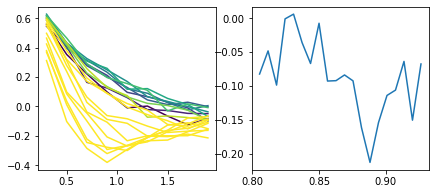

In [207]:
end = []
fig,ax  = subplots(1,2,figsize = (7,3))
for i in range(len(control_amps)):
    expe = experiment_pi_check.load(data_folder + f'pi_check/D7Qubit_pi_pulse_check_sweep_amp_{i}')
    out = (expe.store_arr[:,0,:].mean(-1))/1e-3
    out = imag(out)
    ax[0].plot(expe.number_of_Pulses[1:]*expe.control_duration/1e-6,out[1:],color = cm.viridis(i/10))
    end.append(out[-1])
ax[1].plot(control_amps,end)


## ramsey with frequency

In [800]:
import qkit.measure.presto.ramsey_chevron as presto_ramsey_chevron

In [801]:
reload(presto_ramsey_chevron)

<module 'qkit.measure.presto.ramsey_chevron' from 'C:\\qkit\\qkit\\measure\\presto\\ramsey_chevron.py'>

In [824]:
mw_drive.set_status(False)

True

In [838]:
experiment_ramsey_chevron = presto_ramsey_chevron.RamseyChevron({ 
            'readout_freq':  7.327e9,
            'control_freq_center' : 4.1321e9,
            'control_freq_span': 5e6,
            'control_freq_nr' : 21,
            'readout_amp' : 0.05,
            'control_amp' : 0.1055,
            'readout_duration': 1250e-9,
            'match_duration' :(1250 -250)*1e-9,
            'readout_match_delay' :  (110+250)*1e-9,
            'delay_arr' : arange(0,5000,6*30)*1e-9,
            'control_duration' : 400e-9,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'num_averages':2000})

In [839]:
experiment_ramsey_chevron.experiment_name = 'D7Qubit_ramsey_chevron_2'
experiment_ramsey_chevron.run(presto_address)

Measurement sequence processed in 2.0ms
Expected measurement time: 1m 18.3s
Uploading measurement parameters: 103.7ms
Measurement completed in: 1m 18.6s
Total time: 1m 20.6s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_ramsey_chevron_2


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_ramsey_chevron_2.h5'

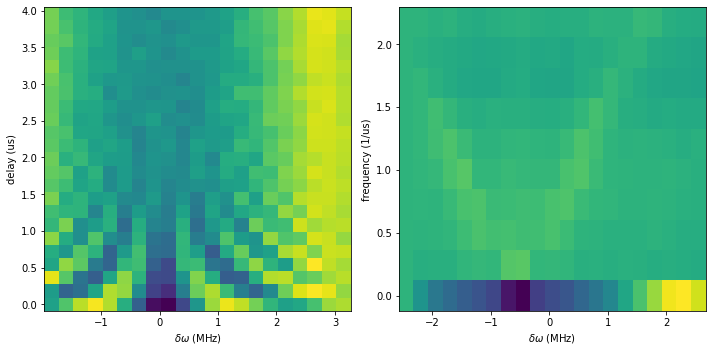

In [842]:
expe = experiment_ramsey_chevron.load(data_folder +  'D7Qubit_ramsey_chevron_1')
out = expe.match_arr.reshape((2,expe.num_averages,expe.control_freq_nr,len(expe.delay_arr))).mean(1)
out = array([IQtoval(out[0,i]+1j*out[1,i]) for i in range((expe.control_freq_nr))]).T
#pcolormesh(expe.control_freq_arr-,(expe.delay_arr),out.T)

delay = (expe.delay_arr)/1e-6
freq_pulse = expe.control_freq_arr/1e9

fig,ax = subplots(1,2,figsize = (10,5))
ax[0].pcolormesh((freq_pulse-4.1321)*1e3,delay[:],out[:],shading = 'nearest')


Afft = numpy.fft.fft(out.T)
freq = numpy.fft.fftfreq(len(delay), d=(-delay[1]+delay[0]))
out -= out[0].mean()
A = abs(Afft[:,:]).T
A =A.T - A.T[0]
ax[1].pcolormesh((freq_pulse[:]-4.1327)*1e3,abs(freq[:10]),A[:,:10].T,shading = 'nearest')
ax[0].set_xlabel(r'$\delta \omega$ (MHz)')
ax[1].set_xlabel(r'$\delta \omega$ (MHz)')
ax[0].set_ylabel(r'delay (us)')
ax[1].set_ylabel(r'frequency (1/us)')
tight_layout()

## T1

In [689]:
import qkit.measure.presto.t1 as presto_t1

In [690]:
reload(presto_t1)

<module 'qkit.measure.presto.t1' from 'C:\\qkit\\qkit\\measure\\presto\\t1.py'>

In [691]:
experiment_t1 = presto_t1.T1({
            'readout_freq': 7.327e9,
            'control_freq':4.1335e9,
            'readout_amp':0.15,
            'control_amp': 0.82,
            'readout_duration': 1250e-9,
            'control_duration': 100e-9,
            'sample_duration': 1250e-9,
            'delay_arr':arange(0,30000,12*4)*1e-9,
            'readout_port': 1,
            'control_port': 3,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'readout_sample_delay':(110+250)*1e-9,
            'num_averages': 200})

In [692]:
experiment_t1.experiment_name = 'D7Qubit_t1_1'
experiment_t1.run(presto_address)

Measurement sequence processed in 18.9ms
Expected measurement time: 9.5s
Uploading measurement parameters: 122.7ms
Measurement completed in: 9.8s
Total time: 10.7s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_t1_1


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_t1_1.h5'

T1 =  6.65  us 


Text(0, 0.5, 'output amplitude (mV)')

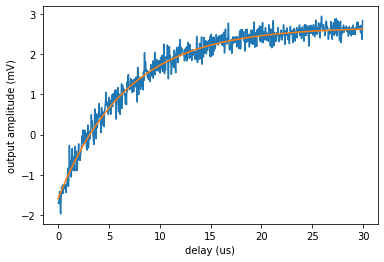

In [693]:
expe = experiment_t1.load(data_folder + 'D7Qubit_t1_1')
out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
delay  =expe.delay_arr/1e-6
plot(delay,out)

funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
p0 = 20,max(out)-min(out),min(out)
p,_ = curve_fit(funcfit,delay,out,p0=p0)
plot(delay,funcfit(delay,*p))
t1_,amp,b = p
print('T1 = ' , round(t1_,2),  ' us ')
xlabel('delay (us)')
ylabel('output amplitude (mV)')

## Ramsey Echo

In [868]:
import qkit.measure.presto.ramsey_echo as presto_ramsey_echo

In [869]:
reload(presto_ramsey_echo)

<module 'qkit.measure.presto.ramsey_echo' from 'C:\\qkit\\qkit\\measure\\presto\\ramsey_echo.py'>

In [870]:
# use pi and pi/2 pulses from Rabi with cloud measurements (pi/2 amp is not the amp of pi divided by 2 because we only reach around 80% with pi)

experiment_ramsey_echo = presto_ramsey_echo.RamseyEcho({ 
            'readout_freq':  7.327e9,
            'control_freq' : 4.13225e9,
            'readout_amp' : 0.05,
            'control_amp_90':0.1634,
            'control_amp_180':0.3286,
            'readout_duration': 1250e-9,
            'control_duration': 250e-9,
            'sample_duration' : (1250 -250)*1e-9,
            'delay_arr' : arange(0,40000,200)*1e-9,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'readout_sample_delay': (110+250)*1e-9,
            'num_averages': 5000})


In [814]:
experiment_ramsey_echo.experiment_name = f'D7Qubit_ramsey_echo_5'
experiment_ramsey_echo.run(presto_address)

Measurement sequence processed in 8.9ms
Expected measurement time: 16.4s
Uploading measurement parameters: 111.7ms
Measurement completed in: 16.6s
Total time: 17.1s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_ramsey_echo_6


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_ramsey_echo_6.h5'

T2 echo =  10.24  us 


Text(0, 0.5, 'output amplitude (mV)')

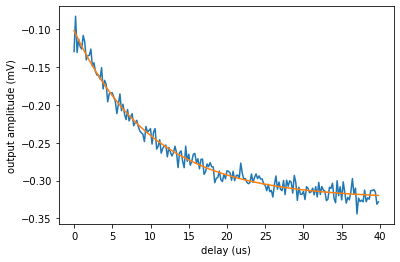

In [876]:
expe = experiment_ramsey_echo.load(data_folder + f'D7Qubit_ramsey_echo_5')
out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
delay  =expe.delay_arr/1e-6
plot(delay,out)

funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
p0 = 1,max(out)-min(out),min(out)
p,_ = curve_fit(funcfit,delay,out,p0=p0)
plot(delay,funcfit(delay,*p))
t1_,amp,b = p
print('T2 echo = ' , round(t1_,2),  ' us ')
xlabel('delay (us)')
ylabel('output amplitude (mV)')

# Two tone flux sweep

In [239]:
experiment_two_tone_pulsed = presto_two_tone_pulsed.TwoTonePulsed({
            'readout_freq' : 7.3255e9,
            'control_freq_center' : 4.13e9,
            'control_freq_span' : 0.02e9,
            'control_freq_nr' : 151,
            'num_averages' : 2000,
            'readout_amp':0.005,
            'control_amp':0.1,
            'readout_duration': 1250e-9,
            'control_duration' : 600e-9,
            'sample_duration' : 1000e-9,
            'readout_sample_delay':(110+250)*1e-9,
            'sample_port' : 1,
            'control_port':3,
            'readout_port': 1,
            'wait_delay' : 50e-6})

In [240]:
bias_yoko = -3.484848e-3 + linspace(-0.02e-3,0.02e-3,21)
if 1:
    for i in range(len(bias_yoko)):
        yoko.ramp_current(bias_yoko[i],1e-5)
        experiment_two_tone_pulsed.experiment_name = f'Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_{i}_0'
        experiment_two_tone_pulsed.run(presto_address,print_time= False)
    

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_0_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_1_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_2_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_3_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_4_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_5_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_6_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_7_0
Data saved to: C:/qkit/qkit/data/20230119_Sionlu

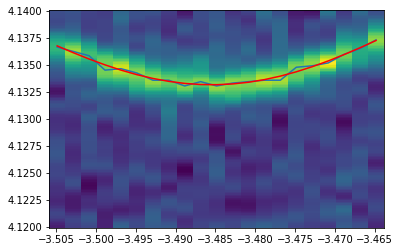

In [454]:
out = zeros((len(bias_yoko),experiment_two_tone_pulsed.control_freq_nr))
for i in range(len(bias_yoko)):
    expe = experiment_two_tone_pulsed.load(data_folder +f'Two_tone_pulse_freq_sweep/D7Qubit_two_tone_pulsedsweep_{i}_0')
    out[i] = gaussian_filter(abs(unwrap(angle(expe.store_arr[:,0,:].mean(-1)))),4)
pcolormesh(bias_yoko/1e-3,expe.control_freq_arr/1e9,out.T,shading = 'nearest')

f_fluxo = expe.control_freq_arr[argmax(out,axis = 1)]
plot(bias_yoko/1e-3,f_fluxo/1e9)
if 1:
    pol = polyfit(bias_yoko/1e-3,f_fluxo,deg = 4)
    plot(bias_yoko/1e-3,polyval(pol,bias_yoko/1e-3)/1e9,'r')
    dc_bias_0 = linspace(-3.5,-3.46,100)[argmin(polyval(pol,linspace(-3.5,-3.46,100))/1e9)]
    dc_bias_0 = round(dc_bias_0,6)
dc_bias_0 
yoko.ramp_current(-3.485455e-3,0.5e-5)

## redo T2 echo ???

In [266]:
experiment_ramsey_echo.experiment_name = f'D7Qubit_ramsey_echo_1'
experiment_ramsey_echo.run(presto_address)

Measurement sequence processed in 27.9ms
Expected measurement time: 1m 20.1s
Uploading measurement parameters: 130.7ms
Measurement completed in: 1m 20.4s
Total time: 1m 21.2s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_ramsey_echo_1


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_ramsey_echo_1.h5'

T2 =  0.33  us 


Text(0, 0.5, 'output amplitude (mV)')

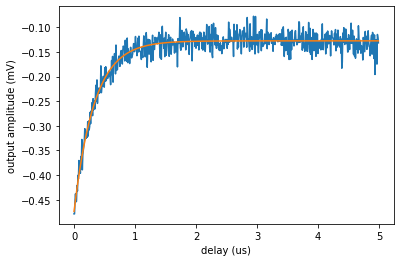

In [273]:
expe = experiment_ramsey_echo.load(data_folder + f'D7Qubit_ramsey_echo_1')
out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
delay  =expe.delay_arr/1e-6
plot(delay,out)

funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
p0 = 1,max(out)-min(out),min(out)
p,_ = curve_fit(funcfit,delay,out,p0=p0)
plot(delay,funcfit(delay,*p))
t1_,amp,b = p
print('T2 = ' , round(t1_,2),  ' us ')
xlabel('delay (us)')
ylabel('output amplitude (mV)')

## T2 

In [999]:
import qkit.measure.presto.ramsey as presto_ramsey

In [1000]:
reload(presto_ramsey)

<module 'qkit.measure.presto.ramsey' from 'C:\\qkit\\qkit\\measure\\presto\\ramsey.py'>

In [1001]:
experiment_ramsey = presto_ramsey.Ramsey({ 
            'readout_freq':  7.327e9,
            'control_freq' :  4.1327e9,
            'readout_amp' : 0.05,
            'control_amp': 0.1634,
            'readout_duration': 1250e-9,
            'control_duration': 250e-9,
            'sample_duration' : (1250 -250)*1e-9,
            'delay_arr' : arange(0,40000,4*50)*1e-9,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'readout_sample_delay': (110+250)*1e-9,
            'num_averages':2000})
    

In [1002]:
experiment_ramsey.experiment_name = f'D7Qubit_ramsey_1'
experiment_ramsey.run(presto_address)

Measurement sequence processed in 9.0ms
Expected measurement time: 32.7s
Uploading measurement parameters: 109.7ms
Measurement completed in: 32.9s
Total time: 33.4s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_ramsey_1


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_ramsey_1.h5'

T2 =  4.23  us 


Text(0, 0.5, 'output amplitude (mV)')

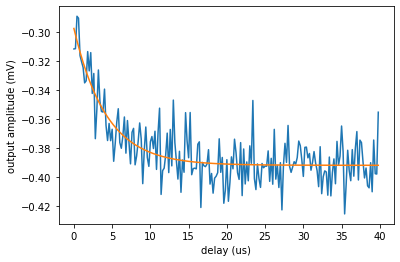

In [1003]:
expe = experiment_ramsey.load(data_folder + f'D7Qubit_ramsey_1')
out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
delay  =expe.delay_arr/1e-6
plot(delay,out)

funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
p0 = 1,max(out)-min(out),min(out)
p,_ = curve_fit(funcfit,delay,out,p0=p0)
plot(delay,funcfit(delay,*p))
t2_,amp,b = p
print('T2 = ' , round(t2_,2),  ' us ')
xlabel('delay (us)')
ylabel('output amplitude (mV)')

In [1004]:
t2_ramsey = t2_

#  Rabi with cloud measurement

 ## Make IQ cloud and fit mixture

In [725]:

experiment_cloud = presto_IQ_cloud.IQCloud({
        'readout_freq': 7.3259e9,
        'control_freq' :4.1325e9,
        'readout_amp' : 0.19,
        'control_amp':0.15,
        'readout_duration': 1250e-9,
        'control_duration' : 300e-9,
        'match_duration' :(1000)*1e-9,
        'readout_match_delay' :  (110+250)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 40e-6,
        'num_repeat': 20000})



In [726]:
experiment_cloud.experiment_name = 'IQ_cloud_test_3'
experiment_cloud.run(presto_address)

Measurement sequence processed in 0.0e+00
Expected measurement time: 831.0ms
Uploading measurement parameters: 103.7ms
Measurement completed in: 1.1s
Total time: 1.5s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_test_3


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\IQ_cloud_test_3.h5'

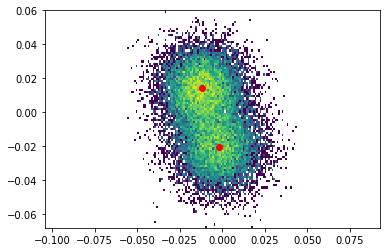

In [727]:
expe = experiment_cloud.load(data_folder+f'IQ_cloud_test_3')
IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
gmm = mixture.fit(IQ.T)
out = gmm.means_
hist2d((IQ)[0],(IQ)[1],bins = 100,norm = colors.LogNorm() );
axis('equal')
scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'r')
scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')


## Rabi

In [758]:
import qkit.measure.presto.rabi_clouds as presto_rabi_clouds

In [759]:
reload(presto_rabi_clouds)

<module 'qkit.measure.presto.rabi_clouds' from 'C:\\qkit\\qkit\\measure\\presto\\rabi_clouds.py'>

In [764]:
experiment_rabi_clouds = presto_rabi_clouds.RabiCloud({
        'readout_freq':  7.3259e9,
        'control_freq' :4.13325e9,
        'readout_amp' : 0.15,
        'control_amp_arr': linspace(0.01,0.6,51),
        'readout_duration': 1250e-9,
        'control_duration' : 250e-9,
        'match_duration' :(1250 -250)*1e-9,
        'readout_match_delay' :  (110+250)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 30e-6,
        'num_average': 2000})

In [765]:
freq_qubit =  4.13325e9 + linspace(-5e6,5e6,11)
for i_freq in range(len(freq_qubit )):
    experiment_rabi_clouds.control_freq = freq_qubit[i_freq]
    experiment_rabi_clouds.experiment_name = f'rabi_sweep_freq/QD7_rabi_cloud_{i_freq}_1'
    experiment_rabi_clouds.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_0_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_1_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_2_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_3_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_4_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_5_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_6_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_7_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_8_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/rabi_sweep_freq/QD7_rabi_cloud_9_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi

max inversion 0.8109999999999999
best pi pulse : 4132.25 MHz    0.3286 V
pi/2 pulse : 4132.25 MHz    0.16340000000000002 V


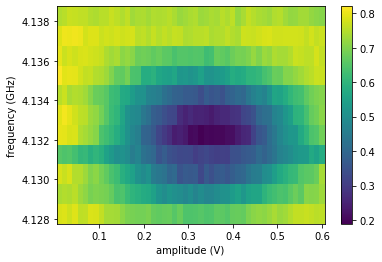

In [770]:

expe  = experiment_rabi_clouds.load(data_folder+ f'rabi_sweep_freq/QD7_rabi_cloud_{i_freq}_1')
weights = zeros((len(freq_qubit ),len(expe.control_amp_arr)))
for i_freq in range(len(freq_qubit )):
    expe  = experiment_rabi_clouds.load( data_folder+ f'rabi_sweep_freq/QD7_rabi_cloud_{i_freq}_1')
    IQ_ = expe.match_arr

    IQ_ = IQ_.reshape((2,expe.num_average,len(expe.control_amp_arr)))

    for i in range(len(expe.control_amp_arr)):
        IQ = IQ_[:,:,i]*sqrt_n_V/(expe.match_duration/1e-9)
        out = gmm.predict(IQ.T)
        weights[i_freq,i] = sum(out)/expe.num_average

p = pcolormesh(expe.control_amp_arr,freq_qubit/1e9,weights,shading = 'nearest')
colorbar(p)

xlabel('amplitude (V)')
ylabel('frequency (GHz)')
print('max inversion' , 1-np.min(weights))

i,j = unravel_index(argmin(weights),(len(freq_qubit ),len(expe.control_amp_arr)))
print('best pi pulse :', freq_qubit[i]/1e6,'MHz   ',expe.control_amp_arr[j], 'V')


j = argmin(abs(weights[i,:j]-0.5))
print('pi/2 pulse :', freq_qubit[i]/1e6,'MHz   ',expe.control_amp_arr[j], 'V')

4.12925


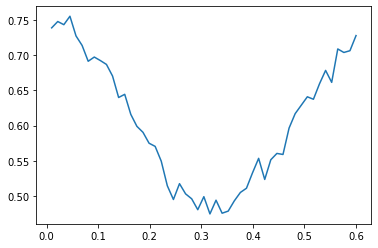

In [767]:
fig,ax = subplots()

ax.plot(expe.control_amp_arr,weights[i,:],)
print(freq_qubit[i]/1e9)

 ## Make IQ cloud with phase change because people like to have things in order

In [365]:

experiment_cloud = presto_IQ_cloud.IQCloud({
        'readout_freq': 7.3259e9,
        'control_freq' :4.1325e9,
        'readout_amp' : 0.19,
        'readout_phase' : 0.9,
        'control_amp':0.15,
        'readout_duration': 1250e-9,
        'control_duration' : 300e-9,
        'match_duration' :(1000)*1e-9,
        'readout_match_delay' :  (110+250)*1e-9,
        'readout_port' : 1,
        'control_port' :3 ,
        'sample_port': 1,
        'wait_delay': 40e-6,
        'num_repeat': 100000})



In [366]:
experiment_cloud.experiment_name = 'IQ_cloud_test_2'
experiment_cloud.run(presto_address)

Measurement sequence processed in 0.0e+00
Expected measurement time: 4.2s
Uploading measurement parameters: 103.8ms
Measurement completed in: 4.5s
Total time: 4.9s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/IQ_cloud_test_2


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\IQ_cloud_test_2.h5'

Text(0, 0.5, 'Q ( $\\sqrt{n}$)')

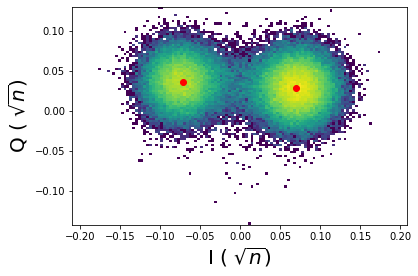

In [367]:
expe = experiment_cloud.load(data_folder+f'IQ_cloud_test_2')
IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
gmm = mixture.fit(IQ.T)
out = gmm.means_
hist2d((IQ)[0],(IQ)[1],bins = 100,norm = colors.LogNorm() );
axis('equal')
scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'r')
scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
xlabel(r'I ( $\sqrt{n}$)',fontsize = 20)
ylabel(r'Q ( $\sqrt{n}$)',fontsize = 20)

## active reset to 1

In [368]:
import qkit.measure.presto.active_reset as presto_active_reset

In [369]:
reload(presto_active_reset)

<module 'qkit.measure.presto.active_reset' from 'C:\\qkit\\qkit\\measure\\presto\\active_reset.py'>

In [403]:

experiment_reset = presto_active_reset.ActiveReset({
        'control_freq' :4.13325e9,
        'readout_freq':  7.3259e9,
        'control_duration' :  200e-9,
        'control_amp' :  0.4194,
        'readout_amp' : 0.19,
        'readout_phase' : 0.9,
        'pos_e':gmm.means_[0,0]+1j*gmm.means_[0,1],
        'pos_g':gmm.means_[1,0]+1j*gmm.means_[1,1],
        'threshold': -0,
        'readout_duration': 1250e-9,
        'match_duration' :(1250 -250)*1e-9,
        'readout_match_delay' : (110+250)*1e-9,
        'readout_port' : 1,
        'sample_port': 1,
        'control_port': 3,
        'n_repeat' : 50000,
        'wait_delay': 30e-6})


In [404]:
experiment_reset.experiment_name = f'QD7_reset_0'
experiment_reset.run(presto_address,print_time= False)

0.9
1000
1000
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/QD7_reset_0


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\QD7_reset_0.h5'

(0.79892, 0.05)

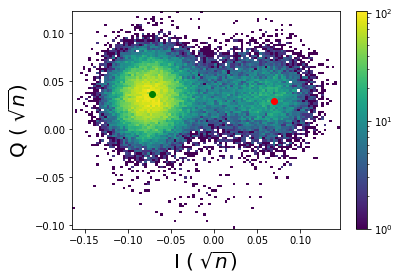

In [405]:
expe = experiment_reset.load(data_folder+f'QD7_reset_0')
expe.match_arr.shape
IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
fig,ax = subplots()

h = ax.hist2d((IQ[:])[0],(IQ[: ])[1],bins = 100,norm = colors.LogNorm() );
fig.colorbar(h[3], ax=ax)

ax.set_xlabel(r'I ( $\sqrt{n}$)',fontsize = 20)
ax.set_ylabel(r'Q ( $\sqrt{n}$)',fontsize = 20)

ax.scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'g')
ax.scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
1-sum(gmm.predict(IQ.T)/expe.n_repeat),200/4000

## szilard engine : N active resets and delay before IQ cloud measurement#

In [401]:
import qkit.measure.presto.szilard_engine as presto_szilard_engine

In [402]:
reload(presto_szilard_engine)

<module 'qkit.measure.presto.szilard_engine' from 'C:\\qkit\\qkit\\measure\\presto\\szilard_engine.py'>

In [459]:

experiment_szilard = presto_szilard_engine.Szilard({
        'control_freq' :4.13325e9,
        'readout_freq': 7.3259e9,
        'readout_duration': 1250e-9,
        'readout_amp' : 0.19,
        'match_duration' :(1250 -250)*1e-9,
        'readout_match_delay' :  (110+250)*1e-9,
        'delay': 40000e-9,
        'control_duration' :  200e-9,
        'control_amp' :  0.4194,
        'readout_phase' : 0.9,
        'reset_time':600e-9,
        'pos_e':gmm.means_[0,0]+1j*gmm.means_[0,1],
        'pos_g':gmm.means_[1,0]+1j*gmm.means_[1,1],
        'threshold': -0.,
        'readout_port' : 1,
        'sample_port': 1,
        'control_port': 3,
        'n_repeat' : 3000,
        'n_reset':1,
        'wait_delay': 1500e-6})


In [412]:
n_repeat = range(1,300,25)
for i in range(len(n_repeat)):
    experiment_szilard.n_reset = n_repeat[i]
    experiment_szilard.experiment_name = f'szilard_0/QD7_szilard_{i}_0'
    experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_0_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_1_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_2_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_3_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_4_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_5_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_6_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_7_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_8_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_9_0
*** ERROR: OCM 3
Data saved to: C:/qki

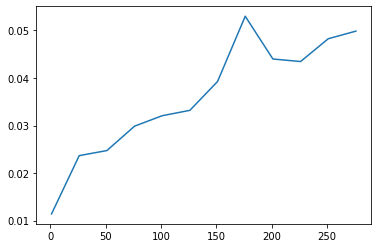

In [414]:
n_repeat = range(1,300,25)
sum_fit = zeros((len(n_repeat)))
for i in range(len(n_repeat)):
    expe = experiment_szilard.load(data_folder + f'szilard_0/QD7_szilard_{i}_0')
    expe.match_arr.shape
    IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
    #fig,ax = subplots()

    #h = ax.hist2d((IQ[:])[0],(IQ[: ])[1],bins = linspace(-0.16,0.16,100),norm = colors.LogNorm() );
    #fig.colorbar(h[3], ax=ax)

    #ax.set_xlabel(r'I ( $\sqrt{n}$)',fontsize = 20)
    #ax.set_ylabel(r'Q ( $\sqrt{n}$)',fontsize = 20)

    #ax.scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'g')
    #ax.scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
    sum_fit[i] = 1-sum(gmm.predict(IQ.T)/expe.n_repeat)
plot(n_repeat,sum_fit)

In [415]:
experiment_szilard.delay = 300e-6
n_repeat = range(1,300,25)
for i in range(len(n_repeat)):
    experiment_szilard.n_reset = n_repeat[i]
    experiment_szilard.experiment_name = f'szilard_0/QD7_szilard_{i}_1'
    experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_0_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_1_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_2_1
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_3_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_4_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_5_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_6_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_7_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_8_1
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_9_1
*** ERROR: OCM 3
Data saved to: C:/qki

In [425]:
experiment_szilard.delay = 200e-6
n_repeat = range(1,300,25)
for i in range(len(n_repeat)):
    experiment_szilard.n_reset = n_repeat[i]
    experiment_szilard.experiment_name = f'szilard_0/QD7_szilard_{i}_2'
    experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_0_2
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_1_2
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_2_2
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_3_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_4_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_5_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_6_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_7_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_8_2
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_9_2
*** ERROR: OCM 3
Data saved to: C:/qki

In [428]:
experiment_szilard.delay = 100e-6
n_repeat = range(1,300,25)
for i in range(len(n_repeat)):
    experiment_szilard.n_reset = n_repeat[i]
    experiment_szilard.experiment_name = f'szilard_0/QD7_szilard_{i}_3'
    experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_0_3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_1_3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_2_3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_3_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_4_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_5_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_6_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_7_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_8_3
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_9_3
*** ERROR: OCM 3
Data saved to: C:/qki

In [439]:
experiment_szilard.delay = 20e-6
n_repeat = range(1,300,25)
for i in range(len(n_repeat)):
    experiment_szilard.n_reset = n_repeat[i]
    experiment_szilard.experiment_name = f'szilard_0/QD7_szilard_{i}_4'
    experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_0_4
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_1_4
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_2_4
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_3_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_4_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_5_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_6_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_7_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_8_4
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_0/QD7_szilard_9_4
*** ERROR: OCM 3
Data saved to: C:/qki

Text(0, 0.5, 'p(delay)')

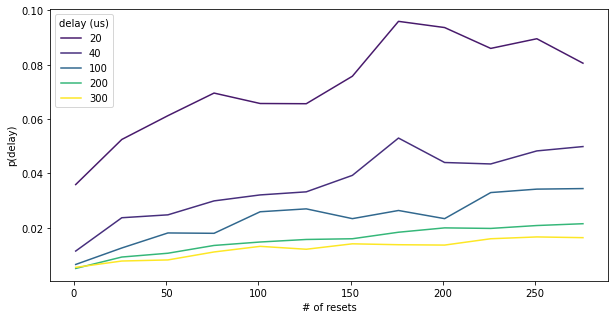

In [440]:
figure(figsize  =(10,5))
for j in [4,0,3,2,1]:
    n_repeat = range(1,300,25)
    sum_fit = zeros((len(n_repeat)))
    for i in range(len(n_repeat)):
        expe = experiment_szilard.load(data_folder + f'szilard_0/QD7_szilard_{i}_{j}')
        expe.match_arr.shape
        IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
        #fig,ax = subplots()

        #h = ax.hist2d((IQ[:])[0],(IQ[: ])[1],bins = linspace(-0.16,0.16,100),norm = colors.LogNorm() );
        #fig.colorbar(h[3], ax=ax)

        #ax.set_xlabel(r'I ( $\sqrt{n}$)',fontsize = 20)
        #ax.set_ylabel(r'Q ( $\sqrt{n}$)',fontsize = 20)

        #ax.scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'g')
        #ax.scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
        sum_fit[i] = 1-sum(gmm.predict(IQ.T)/expe.n_repeat)
    plot(n_repeat,sum_fit,label = round(expe.delay/1e-6),color = cm.viridis(round(expe.delay/1e-6)/300 ))
legend(title = 'delay (us)')
xlabel('# of resets')
ylabel('p(delay)')

In [460]:
for j,delay in enumerate([5,10,25,50,75,100,150,200,300,500,1000]):
    experiment_szilard.delay = delay*1e-6
    n_repeat = range(1,300,25)
    for i in range(len(n_repeat)):
        experiment_szilard.n_reset = n_repeat[i]
        experiment_szilard.experiment_name = f'szilard_1/QD7_szilard_{i}_{j}'
        experiment_szilard.run(presto_address,print_time= False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_0_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_1_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_2_0
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_3_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_4_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_5_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_6_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_7_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_8_0
*** ERROR: OCM 3
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/szilard_1/QD7_szilard_9_0
*** ERROR: OCM 3
Data saved to: C:/qki

0.0003333333333333333

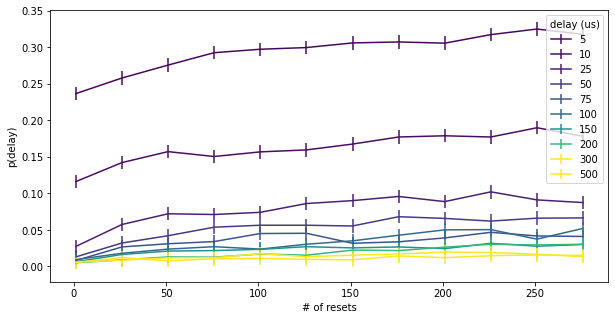

In [468]:
figure(figsize  =(10,5))
for j in range(10):
    n_repeat = range(1,300,25)
    sum_fit = zeros((len(n_repeat)))
    for i in range(len(n_repeat)):
        expe = experiment_szilard.load(data_folder + f'szilard_1/QD7_szilard_{i}_{j}')
        expe.match_arr.shape
        IQ = expe.match_arr*sqrt_n_V/(expe.match_duration/1e-9)
        #fig,ax = subplots()

        #h = ax.hist2d((IQ[:])[0],(IQ[: ])[1],bins = linspace(-0.16,0.16,100),norm = colors.LogNorm() );
        #fig.colorbar(h[3], ax=ax)

        #ax.set_xlabel(r'I ( $\sqrt{n}$)',fontsize = 20)
        #ax.set_ylabel(r'Q ( $\sqrt{n}$)',fontsize = 20)

        #ax.scatter(gmm.means_[0,0],gmm.means_[0,1],color = 'g')
        #ax.scatter(gmm.means_[1,0],gmm.means_[1,1],color = 'r')
        sum_fit[i] = 1-sum(gmm.predict(IQ.T)/expe.n_repeat)
    errorbar(x=n_repeat,y=sum_fit,yerr = 1/sqrt(expe.n_repeat)/2,label = round(expe.delay/1e-6),color = cm.viridis(round(expe.delay/1e-6)/300 ))
legend(title = 'delay (us)')
xlabel('# of resets')
ylabel('p(delay)')

1/(expe.n_repeat)

# T2 CPMG

In [845]:
import qkit.measure.presto.ramsey_CPMG as presto_ramsey_CPMG

In [889]:
reload(presto_ramsey_CPMG)

<module 'qkit.measure.presto.ramsey_CPMG' from 'C:\\qkit\\qkit\\measure\\presto\\ramsey_CPMG.py'>

In [ ]:
np.round( arange(1200,40000,240)*1e-9 /2 / 4,9)*1e9

In [934]:
# use pi and pi/2 pulses from Rabi with cloud measurements (pi/2 amp is not the amp of pi divided by 2 because we only reach around 80% with pi)

experiment_ramsey_CPMG = presto_ramsey_CPMG.RamseyCPMG({ 
            'readout_freq':  7.327e9,
            'control_freq' : 4.13225e9,
            'readout_amp' : 0.05,
            'control_amp_90':0.1634,
            'control_amp_180':0.3286,
            'readout_duration': 1250e-9,
            'control_duration': 250e-9,
            'sample_duration' : (1250 -250)*1e-9,
            'delay_arr' : arange(1200,100000,400)*1e-9,
            'n_pulses' : 10,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'readout_sample_delay': (110+250)*1e-9,
            'num_averages': 5000})


In [931]:
experiment_ramsey_CPMG.experiment_name = f'D7Qubit_ramsey_CPMG_4'
experiment_ramsey_CPMG.run(presto_address)

Measurement sequence processed in 25.0ms
Expected measurement time: 2m 18.5s
Uploading measurement parameters: 128.7ms
Measurement completed in: 2m 18.8s
Total time: 2m 20.5s
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/D7Qubit_ramsey_CPMG_4


'C:\\qkit\\qkit\\data\\20230119_Sionludi2\\Mathieu\\D7Qubit_ramsey_CPMG_4.h5'

T2 CPMG 1 pulses =  11.38  us 
T2 CPMG 2 pulses =  21.88  us 
T2 CPMG 4 pulses =  33.61  us 
T2 CPMG 6 pulses =  56.77  us 
T2 CPMG 10 pulses =  933827.68  us 


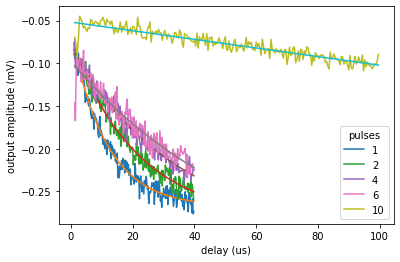

In [932]:
N  = 5

T2_CPMG_all = np.zeros(N)
n_pulses_all = np.zeros(N)

for i in range(N):
    expe = experiment_ramsey_CPMG.load(data_folder + f'D7Qubit_ramsey_CPMG_{i}')
    out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
    delay  =expe.delay_arr/1e-6
    plot(delay,out,label=f"{expe.n_pulses}")

    funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
    p0 = 1,max(out)-min(out),min(out)
    p,_ = curve_fit(funcfit,delay,out,p0=p0)
    plot(delay,funcfit(delay,*p))
    t1_,amp,b = p 
    T2_CPMG_all[i] = t1_
    n_pulses_all[i] = expe.n_pulses
    print(f'T2 CPMG {expe.n_pulses} pulses = ' , round(t1_,2),  ' us ')
    xlabel('delay (us)')
    ylabel('output amplitude (mV)')
    
legend(title="pulses")

Text(0, 0.5, 'T2 (us)')

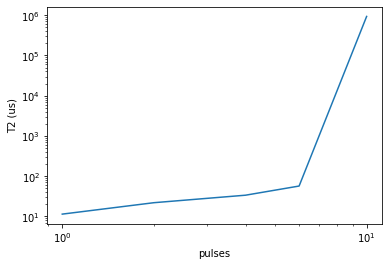

In [933]:
fig, ax = plt.subplots()

ax.loglog(n_pulses_all, T2_CPMG_all)

ax.set_xlabel("pulses")
ax.set_ylabel("T2 (us)")

## Loop

In [989]:
n_pulses_arr = array([1,2,4,8,10,12,20,40,50])
experiment_ramsey_CPMG.delay_arr = arange(10000,1000000,15000)*1e-9

if 0:
    for i in range(8,len(n_pulses_arr)):
        experiment_ramsey_CPMG.n_pulses = n_pulses_arr[i]
        experiment_ramsey_CPMG.experiment_name = f'CPMG/D7Qubit_ramsey_CPMG_{i}_1'
        experiment_ramsey_CPMG.run(presto_address)

T2 CPMG 1 pulses =  9.53  us 
T2 CPMG 2 pulses =  20.55  us 
T2 CPMG 4 pulses =  40.79  us 
T2 CPMG 8 pulses =  72.66  us 
T2 CPMG 10 pulses =  91.01  us 
T2 CPMG 12 pulses =  124.72  us 
T2 CPMG 20 pulses =  213.42  us 
T2 CPMG 40 pulses =  387.82  us 
T2 CPMG 50 pulses =  708.47  us 


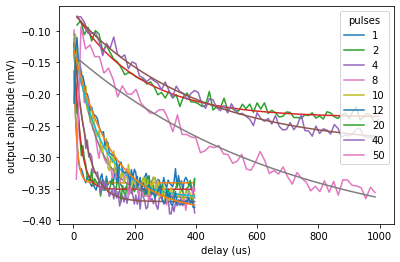

In [990]:
N  = len(n_pulses_arr)
T2_CPMG_all = np.zeros(N)
n_pulses_all = np.zeros(N)

for i in range(N):
    expe = experiment_ramsey_CPMG.load(data_folder + f'CPMG/D7Qubit_ramsey_CPMG_{i}_1')
    out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
    delay  =expe.delay_arr/1e-6
    plot(delay,out,label=f"{expe.n_pulses}")

    funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b
    p0 = 20,max(out)-min(out),min(out)
    p,_ = curve_fit(funcfit,delay,out,p0=p0)
    plot(delay,funcfit(delay,*p))
    t1_,amp,b = p 
    T2_CPMG_all[i] = t1_
    n_pulses_all[i] = expe.n_pulses
    print(f'T2 CPMG {expe.n_pulses} pulses = ' , round(t1_,2),  ' us ')
    xlabel('delay (us)')
    ylabel('output amplitude (mV)')
    
legend(title="pulses")

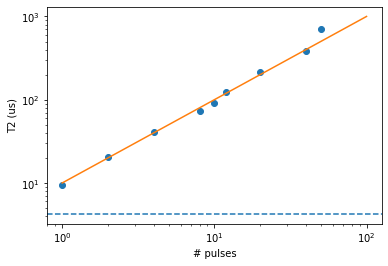

In [1008]:
fig, ax = plt.subplots()

ax.loglog(n_pulses_all, T2_CPMG_all, "o")

ax.set_xlabel("# pulses")
ax.set_ylabel("T2 (us)")

nlog = logspace(0,2,51)

ax.loglog(nlog, 10*nlog**1.0 )

ax.axhline(t2_ramsey, linestyle="--")


# T2 echo Around sweet spot

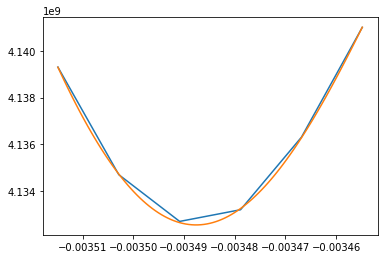

In [1010]:
# previous fit of qubits frequencies (13/01/2023)

bias_yoko = -3.484848e-3 + linspace(-0.03e-3,0.03e-3,6)
center = array([4.1393,4.1347,4.1327,4.1332,4.1363,4.141])*1e9
plot(bias_yoko,center)
pol_freq_current = polyfit(bias_yoko/1e-3,center,deg = 4)
bias_lin =  -3.484848e-3 + linspace(-0.03e-3,0.03e-3,101)
plot(bias_lin,polyval(pol_freq_current,bias_lin/1e-3))


In [1015]:
experiment_ramsey_echo = presto_ramsey_echo.RamseyEcho({ 
            'readout_freq':  7.327e9,
            'control_freq' : 4.13225e9,
            'readout_amp' : 0.05,
            'control_amp_90':0.1634,
            'control_amp_180':0.3286,
            'readout_duration': 1250e-9,
            'control_duration': 250e-9,
            'sample_duration' : (1250 -250)*1e-9,
            'delay_arr' : arange(0,40000,400)*1e-9,
            'readout_port' : 1,
            'control_port' :3 ,
            'sample_port': 1,
            'wait_delay': 60e-6,
            'readout_sample_delay': (110+250)*1e-9,
            'num_averages': 4000})

In [1038]:
bias_currents = -3.465e-3 + linspace(-0.02,0.02,11)*1e-3

In [1020]:
bias_currents = -3.465e-3 + linspace(-0.02,0.02,11)*1e-3

if 1:
    for i in range(len(bias_currents)):
        yoko.ramp_current(bias_currents[i],1e-5)
        experiment_ramsey_echo.control_freq = polyval(pol_freq_current,bias_currents[i]/1e-3)
        experiment_ramsey_echo.experiment_name = f'Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_{i}_0.h5'
        experiment_ramsey_echo.run(presto_address,print_time=False)

Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_0_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_1_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_2_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_3_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_4_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_5_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_6_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_7_1.h5
Data saved to: C:/qkit/qkit/data/20230119_Sionludi2/Mathieu/Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_8_1.h5
Data saved

In [1021]:
funcfit = lambda t,t1,amp,b : amp*exp(-t/t1) + b

In [1023]:
phi0 = 3.6+6.9 # we could do more precise.....

T2 Echo =  12.06  us 
T2 Echo =  10.69  us 
T2 Echo =  10.72  us 
T2 Echo =  13.44  us 
T2 Echo =  12.98  us 
T2 Echo =  17.94  us 
T2 Echo =  13.03  us 
T2 Echo =  13.63  us 
T2 Echo =  10.7  us 
T2 Echo =  11.51  us 
T2 Echo =  10.54  us 


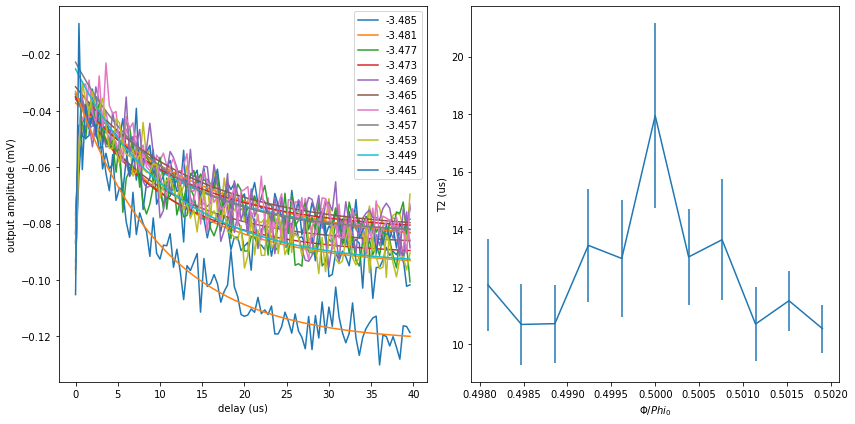

In [1051]:
T2_all = np.zeros_like(bias_currents)
T2_cov_all = np.zeros_like(bias_currents)

fig, ax = subplots(1,2,figsize=(12,6))

for i in range(len(bias_currents)):
    expe = experiment_ramsey_echo.load( data_folder + f'Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_{i}_0.h5')
    out = IQtoval(expe.store_arr[:,0,:].mean(-1))/1e-3
    delay =expe.delay_arr/1e-6
    ax[0].plot(delay,out)
    ax[0].legend(np.round(bias_currents*1e3,6))
    
    
    p0 = 10,max(out)-min(out),min(out)
    p,pcov = curve_fit(funcfit,delay[4:],out[4:],p0=p0)
    T2_all[i],amp,b = p
    T2_cov_all[i] = sqrt(pcov[0,0])
    print('T2 Echo = ' , round(T2_all[i],2),  ' us ')
    ax[0].plot(delay, funcfit(delay,*p) )
    ax[0].set_xlabel('delay (us)')
    ax[0].set_ylabel('output amplitude (mV)')
    
# ax[1].errorbar(bias_currents*1e3, T2_all, yerr=T2_cov_all)
# ax[1].set_xlabel('current (mA)')

ax[1].errorbar((bias_currents*1e3+3.465)/phi0 +0.5, T2_all, yerr=T2_cov_all)
ax[1].set_xlabel(r'$\Phi/Phi_0$')

ax[1].set_ylabel('T2 (us)')

fig.tight_layout()

bouyaaaaaa

In [1054]:
expe = experiment_ramsey_echo.load( data_folder + f'Ramsey_echo_flux_sweep/D7Qubit_ramsey_echo_0_0.h5')

In [1055]:
expe.settings

{'current': {'level': -0.0034850000000000003,
  'output': 'on',
  'source_mode': 'CURR',
  'source_range': '10e-3\n'},
 'mw_drive': {'frequency': 7392700000.0,
  'power': 5.55,
  'power_offset': None,
  'status': True}}